In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.stats import chi2
import seaborn as sns 

## Objective

In this project, we aim to implement a method to estimate the parameters of a linear function. To do so, we assume access to noisy observations of this function. By introducing a Gaussian noise model, we study the properties of this estimator. In particular, we demonstrate the convergence (in a sense that will be specified) of this estimator.

## Preliminaries

Let $\beta_0$, $\beta_1 \in \mathbb{R}$. We consider a function $Y: [0,1] \rightarrow{} \mathbb{R}$ such that for all $x \in [0,1]$,

$$
    Y(x) = β_0 + β_1x
$$

We suppose that $\beta_0$ and $\beta_1$ are unknown parameters that we wish to estimate based on observations of the function $Y$ at $n$ distinct points $(x_1, \dots, x_n)$, with $n \in \mathbb{N}$. We assume that we observe the function $Y$ at these points but that these observations are noisy. In particular, the practitioner observes realizations of

$$
    Y_{obs}(x_i) = Y(x_i) + ε_i , i ∈ {1, \dots, n},
$$

where $(\epsilon_i)_{i \in \mathbb{N}}$ is a sequence of i.i.d. random variables following the centered normal distribution with variance $\sigma^2$ and $\sigma > 0$.

## Least Squares Problem Solution

**S1.** Propose and implement an algorithm to simulate $Y_{obs}^{n} := (Y_{obs}(x_1), \dots, Y_{obs}(x_n))$ when the $(x_1, \dots, x_n)$ are chosen uniformly from $[0,1]$.

In [2]:
class LinearRegressionSimulator:
    def __init__(
            self, 
            beta: np.ndarray, 
            sigma: float,
        ) -> None:
        self.__beta = beta

        if (sigma < 0):
            raise AttributeError("sigma must be non negative")
        self.__sigma = sigma
        
    def simulate(
            self,
            n_obs : int
        ) -> np.ndarray:
        epsilon : np.ndarray = np.\
            random\
            .normal(0, self.__sigma, n_obs)
        
        x = np.array([k for k in np.linspace(0, 1, num= n_obs)])
                
        x = np.insert(
            x.reshape((n_obs, 1)),
            0,
            1,
            axis = 1
        )
        
        return x @ self.__beta + epsilon
    
    @staticmethod
    def get_x(n_obs : int) -> np.ndarray:
        return np.array([k for k in np.linspace(0, 1, num= n_obs)])
    
    
    def get_X(self, n_obs : int) -> np.ndarray:
        x= self.get_x(n_obs)

        X = np.insert(
            x.reshape((n_obs, 1)),
            0,
            1,
            axis = 1
        )

        return X

         
    def get_y(self, n_obs: int) -> np.ndarray:
        x = self.get_x(n_obs)

        x = np.insert(
            x.reshape((n_obs, 1)),
            0,
            1,
            axis = 1
        )

        return x @ self.__beta



In [3]:
# these values are arbitrary
beta = np.array([1,2])
sigma = 0.1
n_obs = 20

In [4]:
lin_reg_simulator = LinearRegressionSimulator(
    beta,
    sigma
)

In [5]:
x = lin_reg_simulator.get_x(n_obs)
y_obs = lin_reg_simulator.simulate(n_obs)

In [6]:
x

array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
       0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
       0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
       0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ])

In [7]:
y_obs

array([0.98449691, 1.12341095, 1.21371599, 1.37307437, 1.47386064,
       1.54266516, 1.67628678, 1.82049317, 1.7873223 , 1.80818924,
       2.20143027, 2.13316705, 2.24267352, 2.43767042, 2.36163852,
       2.63472867, 2.52510867, 2.64309153, 2.75216666, 2.92079041])

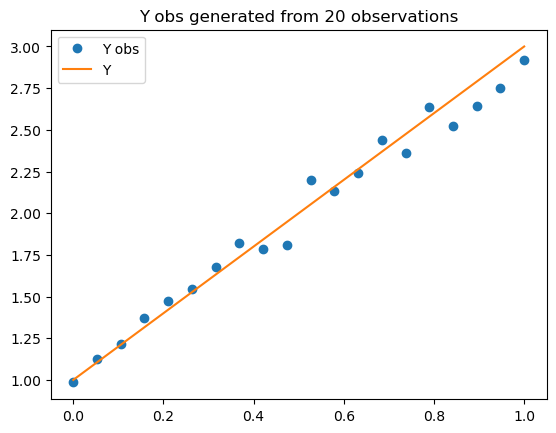

In [8]:
plt.plot(
    x, 
    y_obs, 
    'o',
    label = "Y obs"
)
plt.plot(
    x, 
    lin_reg_simulator.get_y(n_obs),
    label="Y"
)
plt.title(f"Y obs generated from {n_obs} observations")
plt.legend()

**T1**. Write the problem in the form

$$
    Y^n = X^n \beta
$$
where $Y^n = (Y(x_1), \dots, Y(x_n))^T \in \mathbb{R}^n$. We will specify $X^n$ and $\beta$.

To write the problem in the desired form, we need to define the matrix $X^n$ and the parameter vector $\beta$.

As we already done on **S1**, take: 

$$
    X^n = 
        \begin{pmatrix}
            1 & x_1\\
            1 & x_2 \\
            \vdots & \vdots \\
            1 & x_n
        \end{pmatrix}, \

    \beta = \
        \begin{pmatrix}
            \beta_0 \\
            \beta_1
        \end{pmatrix}
$$

**T2.** Show that $\hat{\beta}^n = ((X^n)^T X^n)^{-1}(X^n)^T Y_{obs}^n".

To show that, we first aim to minimize the squared norm $|| Y_{obs}^n - X^n \beta ||^2$.

The squared norm can be expanded as:

$$
    \hat{\beta^n} := \underset{\beta \in \mathbb{R^2}}{\operatorname{arg \ min}} || Y_{obs}^n - X^n \beta || ^2
$$

where $||.||$ is the Euclidean norm in $\mathbb{R}^n$. It can be shown that this solution maximizes the density of $Y_{obs}^n$.

**T2.** Show that $\hat{\beta}^n = ((X^n)^T X^n)^{-1}(X^n)^T Y_{obs}^n.$


We will write the quadratic error, and **for simplicity, we will use the notation $X^n = X$ and $Y_{obs}^n = Y_{obs}$:**

$$
    \begin{aligned}
    E(\beta) & = || (Y_{obs}- X\beta) ||^2 \\
             & = (Y_{obs}- X \beta)^T(Y_{obs} - X \beta) \\
             & = Y_{obs}^T Y_{obs} - 2 Y_{obs}^T X \beta + \beta ^T X ^T X \beta
    \end{aligned}
$$

We need to have $\frac{d E(\beta)}{d \beta} = 0$. Therefore, we have:

$$
    2 \beta^T X^T X - 2 Y_{obs}^T X = 0 \\

    \beta ^T X^T X = Y_{obs}^T X \\

    X^T X \beta = X^T Y_{obs}
$$

Then we find the result:

$$
    \hat{\beta}^n = (X^T X)^{-1} X^T Y_{obs}
$$

**T3.** What is the distribution of $\hat{\beta}^n$? Deduce that $\mathbb{E}[\hat{\beta^n}] = \beta$. We say that the estimator $\hat{\beta}^n$ is unbiased

Knowing that the $(\epsilon_i){i \leq n}$ are i.i.d., the error vector $\epsilon = (\epsilon_i){i \leq n}$ follows a normal distribution with mean $0_n$ and covariance matrix $\sigma^2 I_n$.

$$
    \varepsilon \sim \mathcal{N}(0_{n}, \ \sigma^2 I_{n})  \\

    Y_{obs} = X \beta + \varepsilon \Rightarrow 

    Y_{obs} \sim \mathcal{N}(X \beta, \sigma^2 I_{n})
$$

Then

$$
    \hat{\beta} = (X^T X)^{-1} X^T Y_{obs} \Rightarrow \hat{\beta} \sim \mathcal{N} (A X\beta, \sigma^2 A A^T)
$$

where $A = (X^T X)^{-1} X^T$. We know that

$$
\begin{aligned}
    AX & = (X^T X)^{-1} X^T X \\
       & = I_{n}
\end{aligned}
$$

and

$$
\begin{aligned}
    A A^T & = (X^T X)^{-1}X^T X (X^T X)^{-1} \\
          & = (X^T X)^{-1}
\end{aligned}
$$


Therefore, we conclude that $ \hat{\beta} \sim \mathcal{N} (\beta, \sigma^2 (X^T X)^{-1}) $.


**T4.** Show that $\frac{1}{\sigma} (\hat{\beta^n} - \beta)^T((X^n)^T X^n) (\hat{\beta}^n -\beta)$ follows a $\chi^2_2$ (chi-squared with 2 degrees of freedom) distribution. We denote $q^{\chi^2_2}(r)$ as the quantile of the $\chi^2_2$ distribution at order $r$, and for $\alpha \in [0,1]$, we define:

$$
    \varepsilon_{\alpha, n} \vcentcolon= \left\{  \tilde{\beta} \in \mathbb{R}^2  \frac{1}{\sigma} (\hat{\beta^n} - \beta)^T((X^n)^T X^n) (\hat{\beta}^n -\beta) \leq q^{\chi _2 ^2} (1- \alpha) \right\}
$$

Show that $\mathbb{P} ( \beta \in \varepsilon_{\alpha, n}) = 1- \alpha$. We call $\varepsilon_{\alpha, n}$ the confidence ellipsoid at order $\alpha$.


We have shown that $\hat{\beta} \sim \mathcal{N}(\beta, \sigma^2 (X^T X)^{-1})$.

According to the theorems in the course, this implies that

$$
    \frac{1}{\sigma}(X^T X) ^{1/2} (\hat{\beta} - \beta) \sim \mathcal{N}(0, I)
$$

In other words, each component of $ (X^T X) ^{1/2} (\hat{\beta} - \beta) $ follows an independent standard normal distribution. Moreover, $X^T X$ is symmetric and positive definite, so $((X^T X)^{1/2})^T =(X^T X)^{1/2} $.

Therefore, since we are in 2-dimensional space, the norm of this Gaussian vector follows a $\chi_2^2$ distribution. By writing $||v|| = v^T v$:

$$
    \frac{1}{\sigma^2} (\hat{\beta} - \beta)^T (X^T X) (\hat{\beta} - \beta) \sim \chi_2^2
$$

And, by the definition of confidence intervals, we have found that:

$$
    \mathbb{P} \left(\frac{1}{\sigma^2} (\hat{\beta} - \beta)^T (X^T X) (\hat{\beta} - \beta) \leq q^{\chi_2^2}_{1-\alpha} \right) = 1- \alpha 
$$


**S2.** Propose and implement an algorithm to visualize the confidence ellipsoid and verify the previous result for $\alpha = 0.05$, $\sigma = 0.1$, and $\beta = (0,1), (1,0), (1,2)$. Repeat the experiment by varying the number of observation points $n$. What do you observe?

In [9]:
class LinearRegression:
    def __init__(self) -> None:
        self.coef_ = None
        self.squared_error = None

    def fit(
        self, 
        X : np.ndarray, 
        y : np.ndarray
    ):
        self.coef_ = np.linalg.inv(X.T @ X) @ X.T @ y
        self.squared_error = np.linalg.norm(y - X @ self.coef_)**2

    def predict(
        self,
        X: np.ndarray
    )-> np.ndarray:
        
        if self.coef_ is None:
            raise ValueError("You must run LinearRegression.fit before predicting")
        return X @ self.coef_


In [10]:
def confidence_ellipsoid(
    alpha : float,
    beta: np.ndarray,
    sigma : int = 0.1,
    n_obs : int = 20, 
    n_points_simulation = 100000,
    search_range = 0.2
):
    """Plots the alpha confidence ellipsoid of beta_n obtained 
    from n different points

    Args:
        alpha (float): _description_
        beta (np.ndarray): _description_
        sigma (int, optional): _description_. Defaults to 0.1.
        n_obs (int, optional): _description_. Defaults to 20.
        n_points_simulation (int, optional): _description_. Defaults to 100000.
    """    
    sigma = 0.1
    lin_reg_simulator = LinearRegressionSimulator(beta, sigma)
    model = LinearRegression()

    X = lin_reg_simulator.get_X(n_obs)
    y = lin_reg_simulator.simulate(n_obs)

    model.fit(X, y)
    beta_n = model.coef_

    x_conf = []
    y_conf = []
    for i in range(n_points_simulation):
        beta_tilde_0 = np\
            .random\
            .uniform(
                beta[0] - search_range, beta[0]+ search_range
            )
        beta_tilde_1 = np.\
            random\
            .uniform(
                beta[1]-search_range, beta[1] + search_range
            )

        beta_tilde = np.array([beta_tilde_0, beta_tilde_1])
        q_1_minus_alpha = chi2.ppf(1-alpha, df = 2)
        v = 1/(sigma**2) * (beta_n-beta_tilde).T @ (X.T @ X) @ (beta_n-beta_tilde)

        if v <= q_1_minus_alpha:
            x_conf.append(beta_tilde[0])
            y_conf.append(beta_tilde[1])

    plt.plot(
        x_conf,
        y_conf,
        '.',
        
    )
    plt.title(
        r"$\frac{1}{\sigma^2} (\hat{\beta} - \beta)^T (X^T X) (\hat{\beta} - \beta) \leq q_{1-a}^{\chi_2^2}$" + 
        fr"""
        {int(100*alpha)}% - Confidence ellipsoid for $\beta = ({beta[0]}, {beta[1]})$
        $n = {n_obs}, \sigma = {sigma}$
        """)
    plt.xlabel(r"$\beta_0$")
    plt.ylabel(r"$\beta_1$")

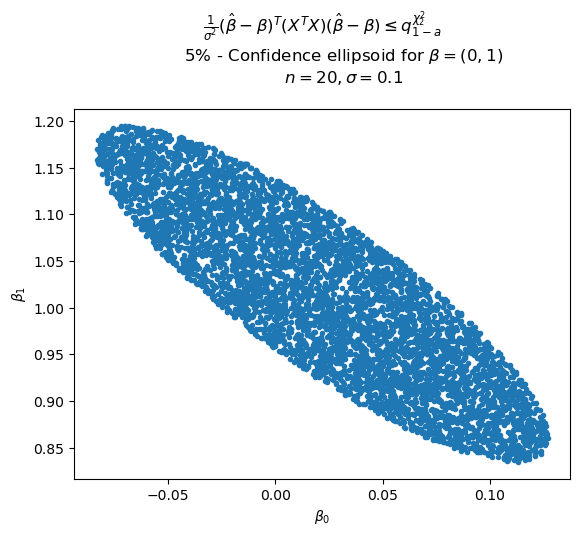

In [11]:
confidence_ellipsoid(
    alpha = 0.05,
    beta = np.array([0,1]) , 
    sigma = 0.1, 
    n_points_simulation=30000
)



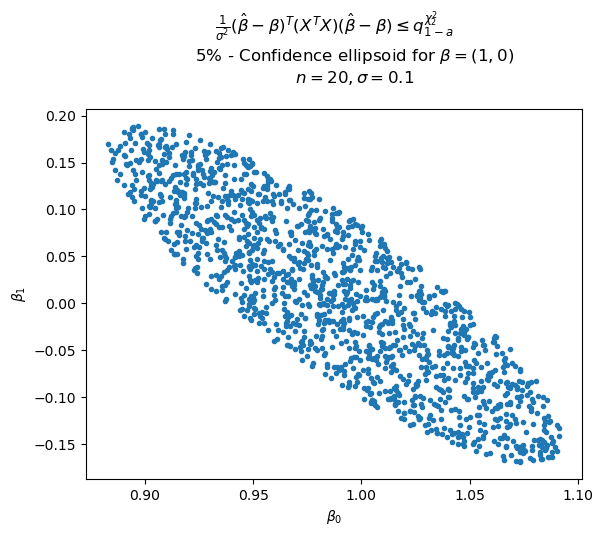

In [12]:
confidence_ellipsoid(
    alpha = 0.05,
    beta = np.array([1,0]) , 
    sigma = 0.1, 
    n_points_simulation=30000,
    search_range=0.4
)

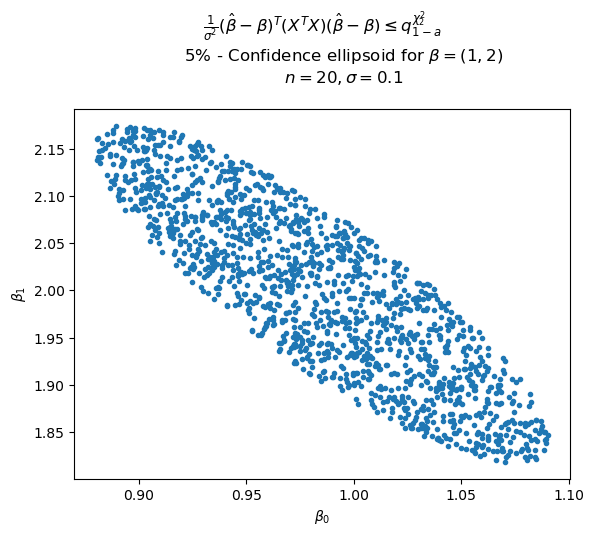

In [13]:
confidence_ellipsoid(
    alpha = 0.05,
    beta = np.array([1,2]) , 
    sigma = 0.1, 
    n_points_simulation=30000,
    search_range=0.4
)

As the number of points in our linear regression increases, $\hat{\beta^n}$ approaches $\beta$, causing the ellipsoid to be less spread out.

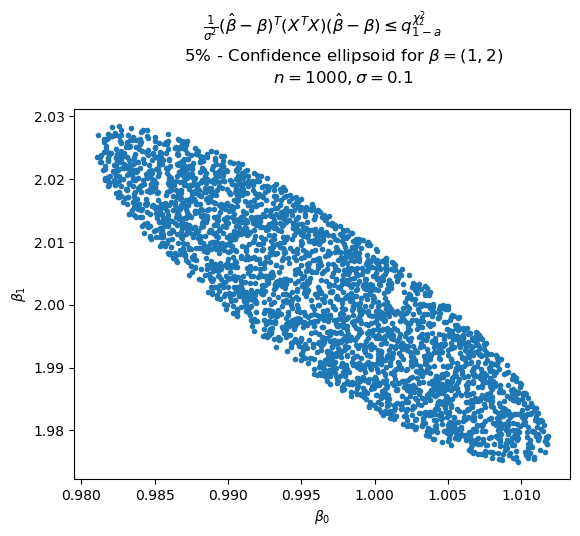

In [14]:
confidence_ellipsoid(
    alpha = 0.05,
    beta = np.array([1,2]) , 
    sigma = 0.1, 
    n_points_simulation=30000,
    n_obs= 1000,
    search_range = 0.04
)


As we decrease the number of points in the regression, we observe the opposite effect, and the ellipsoid becomes more spread out.

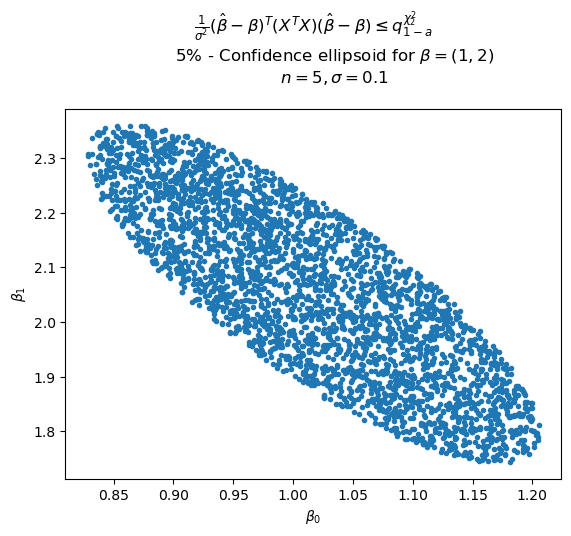

In [15]:
confidence_ellipsoid(
    alpha = 0.05,
    beta = np.array([1,2]) , 
    sigma = 0.1, 
    n_points_simulation=30000,
    n_obs= 5,
    search_range= 0.5
)


## Convergence of the Estimator

We now aim to verify that $\hat{\beta^n}$ converges (in a sense to be specified) to $\beta$. We begin by modifying the way we choose the $(x_1, \dots, x_n)$ in order to reuse these points when modifying $n$. We introduce the sequence $(x_i)_{i \in \mathbb{N}}$ of i.i.d. random variables following the uniform distribution on $[0,1]$, and we will keep the notation $X^n$ for the matrix constructed from the first $n$ observation points $(x_1, \dots, x_n)$. We assume that for all $n \in \mathbb{N}$, $(X^n)^T X^n$ is almost surely invertible.

**S3.** Propose and implement an algorithm to simulate the elements of the sequence.

$$
    (Y_{obs}^n)_{n \in \mathrm{N}} := (Y_{obs}(x_1), \dots, Y_{obs}^n (x_n))_{n \in \mathrm{N}}
$$

In [16]:
class UniformLinearRegressionSimulator:
    def __init__(
            self, 
            beta: np.ndarray, 
            sigma: float,
        ) -> None:
        self.__beta = beta
        self.__x = np.array([])

        if (sigma < 0):
            raise AttributeError("sigma must be non negative")
        self.__sigma = sigma
        
    def simulate(
            self,
            n_obs : int
        ) -> np.ndarray:
        epsilon : np.ndarray = np.\
            random\
            .normal(0, self.__sigma, n_obs)
        
        self.__x = np.random.uniform(0,1, n_obs)
                
        self.__x = np.insert(
            self.__x.reshape((n_obs, 1)),
            0,
            1,
            axis = 1
        )
        
        return self.__x @ self.__beta + epsilon
    
    def get_x(self, only_points : bool = False):
        if only_points:
            return self.__x[:,1]
        return self.__x
    
    def get_y(self):
        return self.__x @ self.__beta

In [17]:
# these values are arbitrary
beta = np.array([1,2])
sigma = 0.1
n_obs = 20

In [18]:
unif_lin_reg_simulator = UniformLinearRegressionSimulator(
    beta,
    sigma
)

In [19]:
y_obs = unif_lin_reg_simulator.simulate(n_obs)
x = unif_lin_reg_simulator.get_x(only_points= True)

In [20]:
y_obs

array([2.82186533, 2.5421391 , 2.38829248, 2.27101949, 2.70010037,
       1.88326479, 2.45609424, 1.29352655, 2.78849569, 1.12704229,
       2.54690506, 2.10439347, 1.21745643, 2.38836507, 1.65074775,
       2.61270223, 1.14403722, 1.76078725, 1.74658506, 2.87236527])

In [21]:
unif_lin_reg_simulator.get_y()

array([2.9568382 , 2.50436737, 2.4115029 , 2.3921403 , 2.77298929,
       1.9063214 , 2.54513484, 1.32420785, 2.93180215, 1.13734158,
       2.56924927, 2.12399656, 1.40026066, 2.38324293, 1.67463608,
       2.7607363 , 1.11589615, 1.71471896, 1.77643902, 2.76193104])

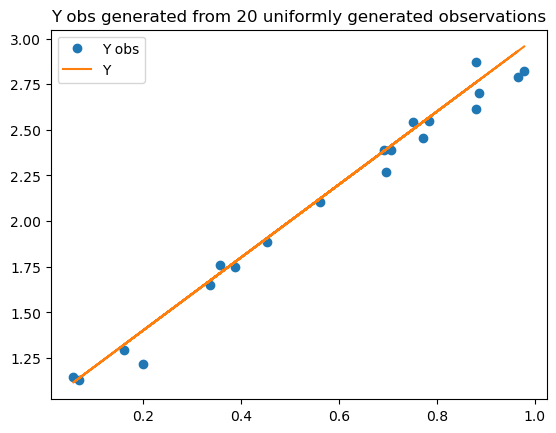

In [22]:
plt.plot(
    x, 
    y_obs, 
    'o',
    label = "Y obs"
)
plt.plot(
    x, 
    unif_lin_reg_simulator.get_y(),
    label="Y"
)
plt.title(f"Y obs generated from {n_obs} uniformly generated observations")
plt.legend()

**T5.** Show that, almost surely:

$$
    \lim_{n \rarr \infty} \frac{1}{n} (X^n)^T X^n = 
        \begin{pmatrix}
            1 & 1/2\\
            1/2 & 1/3
        \end{pmatrix}. \
    
$$

The, show that

$$
    \mathbb{P} \left( \lim_{n \rarr \infty} \hat{\beta^n} = \beta \right) = 1
$$

We know that

$$
\begin{aligned}
    \lim_{n \rarr \infty} \frac{1}{n} (X^n)^T X^n & = 
    \lim_{n \rarr \infty} \frac{1}{n} 
    \begin{pmatrix}
        1 & \dots & 1 \\
        x_1 & \dots & x_n
    \end{pmatrix}

    \begin{pmatrix}
        1 & x_1 \\
        \vdots & \vdots \\
        1 & x_n 
    \end{pmatrix} \\
    
    & = \lim_{n \rarr \infty} \frac{1}{n} 
    \begin{pmatrix}
        n & \sum x_i \\
        \sum x_i & \sum x_i^2
    \end{pmatrix} \\

    & = 
    \begin{pmatrix}
        1 & \mathbb{E}(X_1) \\
        \mathbb{E}(X_1) & \mathbb{E}(X_1^2)
    \end{pmatrix}
\end{aligned}
$$

Since $X_1 \sim \mathcal{U}(0,1)$, $\mathbb{E}(X_1) = 1/2, \ \mathbb{E}(X_1^2) = Var(X_1) + \mathbb{E}(X_1)^2 = 1/3$. Then

$$
    \lim_{n \rarr \infty} \frac{1}{n} (X^n)^T X^n = 
    \begin{pmatrix}
        1 & 1/2 \\
        1/2 & 1/3
    \end{pmatrix}
$$

almost surely. We call $X^*$ this matrix.

As we showed on **T2**, 

$$
    \hat{\beta^n} =  ((X^n)^T X^n)^{-1} (X^n)^T Y_{obs}
$$

Where, $Y_{obs} = X^n \beta + \varepsilon $

Then; 

$$
    \hat{\beta^n} =  
    \left(\frac{1}{n}(X^n)^T X^n \right)^{-1} \left(\frac{1}{n}
    (X^n)^T  (X^n \beta + \varepsilon) \right)
$$

And, we showed that

$$
    \left(\frac{1}{n}(X^n)^T X^n \right)^{-1} \rarr^{p.s.} (X^*)^{-1} \\
     \left(\frac{1}{n}(X^n)^T (X^n \beta + \varepsilon) \right) \rarr^{p.s.} X^* \beta
$$

because $X^*$ it's inversible.

then, $\hat{\beta^n} \rarr^{p.s.} \beta$.

**S4.** Verify numerically this convergence 

We will choose an arbitrary $\beta$, let's assume $\beta =
\begin{pmatrix}
1 \
2
\end{pmatrix}$.
Then, we have $\beta_0 = 1$ and $\beta_1 = 2$.

In [23]:
beta = np.array([1,2])
sigma = 0.1
n_obs = 20

In [24]:
abs_error = []
beta_0 = []
beta_1 = []

for n_obs in range(1,1000):
    y_obs_unif = unif_lin_reg_simulator.simulate(n_obs)
    x_unif = unif_lin_reg_simulator.get_x()

    model = LinearRegression()
    model.fit(x_unif, y_obs_unif)

    abs_error.append(np.linalg.norm(model.coef_ - beta, np.inf))
    beta_0.append(model.coef_[0])
    beta_1.append(model.coef_[1])

We have the converge of estiamators to $\beta_0$ et $\beta_1$:

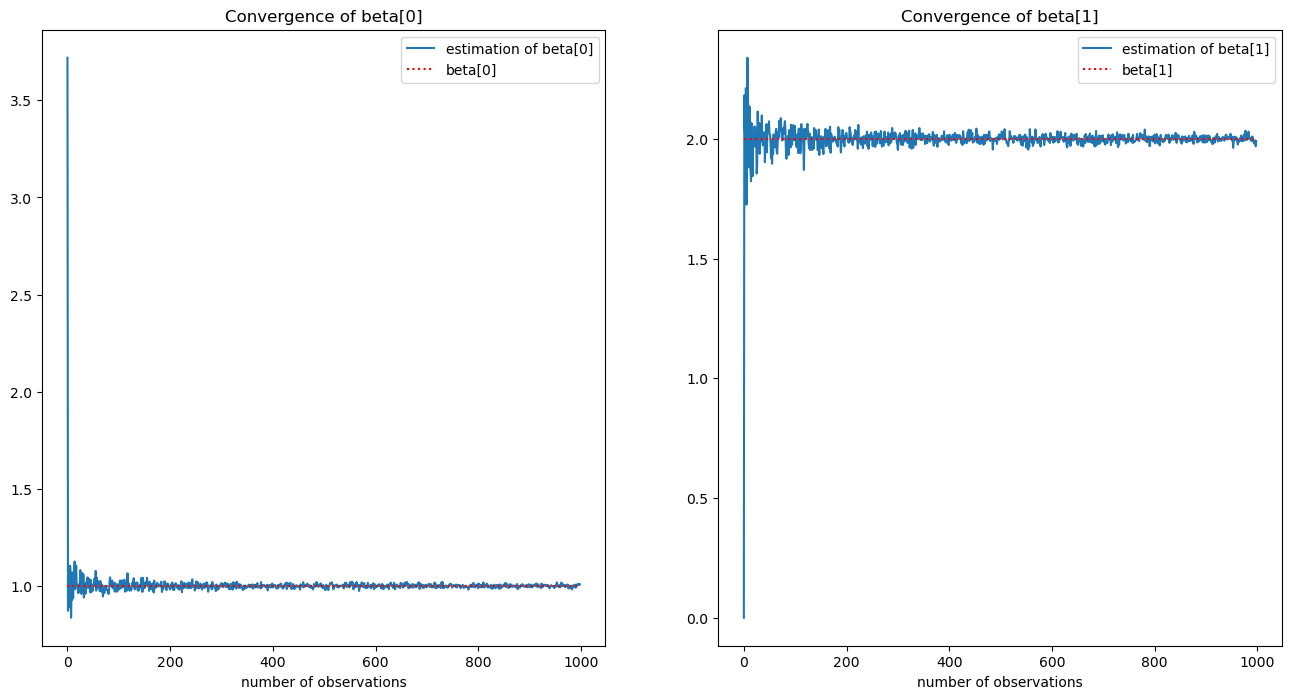

In [25]:
f, (ax1, ax2 ) = plt.subplots(1,2,)
f.set_figwidth(16)
f.set_figheight(8)

ax1.plot(
    beta_0,
    label= "estimation of beta[0]"
)

ax1.plot(
    [beta[0] for i in range(len(beta_0))],
    label = "beta[0]",
    linestyle = 'dotted',
    color = 'red'
)

ax1.set_xlabel("number of observations")
ax1.set_title("Convergence of beta[0]")
ax1.legend()

ax2.plot(
    beta_1,
    label= "estimation of beta[1]",
    # color= 'red'
)

ax2.plot(
    [beta[1] for i in range(len(beta_1))],
    label = "beta[1]",
    linestyle = 'dotted',
    color = 'red'
)

ax2.set_xlabel("number of observations")
ax2.set_title("Convergence of beta[1]")
ax2.legend()

And the error goes to zero 

Text(0.5, 0, 'number of observations')

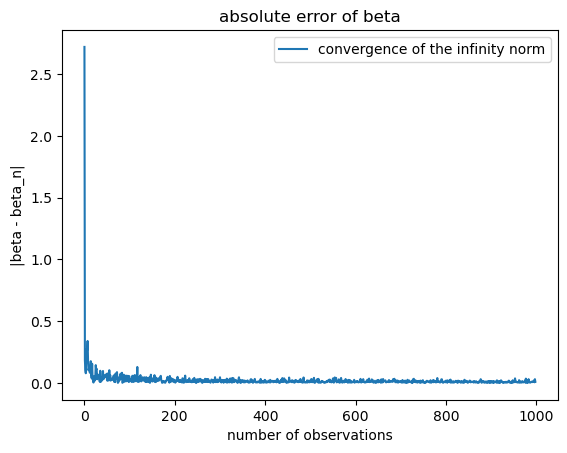

In [26]:
plt.plot(
    abs_error,
    label = "convergence of the infinity norm"
)
plt.title("absolute error of beta")
plt.legend()
plt.ylabel("|beta - beta_n|")
plt.xlabel("number of observations")

## Recursive Calculation of $\hat{\beta^n}$.

The method described so far requires inverting the matrix $(X^n)^T X^n$ for each $n$. We now propose to construct the inverse of this matrix recursively. We recall the formula known as the Woodbury formula: If $A \in \mathbb{R}^{n \times n}, \ U \in \mathbb{R}^{n \times m}, \ C \in \mathbb{R}^{m \times m}, \ V \in \mathbb{R}^{m \times n}$ are matrices such that $A, \ C$, and $C^{-1} + V A^{-1} U$ are invertible, then $A + UCV$ is invertible and

$$
    (A + UCV )^{-1} = A^{-1} - A^{-1}U (C^{-1} + VA^{-1}U)^{-1}VA^{-1}
$$

**T6** Using the Woodbury formula, we can derive the recursive relation:

$$
    ((X^{n+1})^T X^{n+1})^{-1} = ((X^n) X^n)^{-1} - \frac{1}{\alpha} v v^T
$$

where $\alpha > 0$ and $v \in \mathbb{R}^2$ are to be determined.


We will use the Woodbury formula with $A = I_n$, $C = I_n$, $U = a$, and $V = b^T$ where $a, b \in \mathbb{R}^2$.

$$
\begin{aligned}
    (I + a b^T)^{-1} & = I - I a ( I + b^T a I)^{-1} b^T I \\
                & =  I - \frac{a b^T}{( 1 + b^T a )} \\
                & = I - \frac{a b^T}{( 1 + b^T a)} 
\end{aligned}
$$

If we multiply both sides of the equation by $A^{-1}$ on the right and denote $c = Aa$:

$$
\begin{aligned}
    (I + a b^T)^{-1} A^{-1} & = \left( I - \frac{a b^T}{( 1 + a b^T)} \right) A^{-1} \\
    (A + c b^T)^{-1} & = A^{-1} - \frac{A^{-1}c b^T}{( 1 + b^T A^{-1} c )} A ^{-1} \\

\end{aligned}
$$

In the context of the question, we have:

$$
\begin{aligned}
    (X^{n+1})^T X^{n+1} & =  
    \begin{pmatrix}
        n+1 & \sum_{i = 0}^{n+1} x_i \\
        \sum_{i = 0}^{n+1} x_i & \sum_{i = 0}^{n+1} x_i^2
    \end{pmatrix} \\

    & = (X^n)^T X^n + 
    \begin{pmatrix}
        1 & x_{n+1} \\
        x_{n+1} & x_{n+1}^2
    \end{pmatrix}
\end{aligned}
$$

We conclude that:

$$ 
    \begin{pmatrix}
        1 & x_{n+1} \\
        x_{n+1} & x_{n+1}^2
    \end{pmatrix} = 

    \begin{pmatrix}
        1 \\
        x_{n+1}
    \end{pmatrix}
    \begin{pmatrix}
        1 & x_{n+1}
    \end{pmatrix}
$$

Then

$$
    (X^{n+1})^T X^{n+1} = (X^n)^T X^n + u u^T
$$

With

$$
    u = \begin{pmatrix}
        1 \\
        x_{n+1}
    \end{pmatrix}
$$


We use the relation found earlier with $A = (X^n)^T X^n$, $b = c = u$:

$$
    ((X^{n+1})^T X^{n+1})^{ -1} = ((X^n)^T X^n)^{-1} - \frac{((X^n)^T X^n)^{-1}u u^T}{ 1 + u^T ((X^n)^T X^n)^{-1} u } ((X^n)^T X^n) ^{-1} \\
$$

Since $A = (X^n)^T X^n$ is symmetric, we find that $A^{-1} u u^T A^{-1} = (A^{-1} u)(A^{-1} u)^T$. Then:

$$
    ((X^{n+1})^T X^{n+1})^{ -1} = ((X^n)^T X^n)^{-1} - \frac{1}{\alpha} v v^T
$$

Where $\alpha = 1 + u^T ((X^n)^T X^n)^{-1} u$ and $v = ((X^n)^T X^n)^{-1}u$, with $u = \begin{pmatrix}
        1 \\
        x_{n+1}
    \end{pmatrix}$.

**S5.** Deduce a recursive algorithm for constructing $\hat{\beta^n}$. Verify the convergence for $\beta = (0,1), (1,0), (1,2)$ and $\sigma = 0.1$.

In [27]:
class RecursiveLinearRegression: 
    def __init__(self) -> None:
        self.coef_ = None

    @staticmethod
    def invert_recursive_XT_X(X_n: np.ndarray) -> np.ndarray:
        """Given X_n the matrix containing all observations, 
        calculates recursively (X_n ^T X_n)^{-1}
        ```bash
            X_n = (1, x1) 
                  (1, x2) 
                  (..., ... )
                  (1, x_n) 
        ```
    	
        Args:
            X_n (np.ndarray): _description_

        Returns:
            np.ndarray: _description_
        """        
    
        if X_n.shape == (2,2):
            x1 = X_n[0][1]
            x2 = X_n[1][1]

            detA = (x1-x2)**2

            inv = 1/detA * np.array([
                [x1**2 + x2**2, -(x1+x2)],
                [-(x1+x2), 2]
            ]) 

            return inv
        
        X_n_minus_1 = X_n[:-1]
        u = X_n[-1].reshape((2,1))
        
        X_n_minus_1_inv = RecursiveLinearRegression\
            .invert_recursive_XT_X(X_n_minus_1)

        alpha = 1 + float(u.T @ ( X_n_minus_1_inv) @ u)
        
        v = X_n_minus_1_inv @ u

        return X_n_minus_1_inv - 1/alpha * v @ v.T

    def fit(
        self, 
        X : np.ndarray, 
        y : np.ndarray
    ):
        self.coef_ = RecursiveLinearRegression.invert_recursive_XT_X(X) @ X.T @ y

    def predict(
        self,
        X: np.ndarray
    )-> np.ndarray:
        
        if self.coef_ is None:
            raise ValueError("You must run LinearRegression.fit before predicting")
        return X @ self.coef_


In [28]:
x = unif_lin_reg_simulator.get_x()
y_obs = unif_lin_reg_simulator.simulate(n_obs)

In [29]:
lin_reg_recursive_model = RecursiveLinearRegression()
lin_reg_model = LinearRegression()

In [30]:
lin_reg_recursive_model.fit(x, y_obs)
lin_reg_model.fit(x, y_obs)

In [31]:
beta = np.array([1,2])
sigma = 0.1
n_obs = 20


**T7.** Show that $\frac{1}{\sigma^2} || \hat{\epsilon^n} ||^2$ follows the $\chi_{n-2}^2$ (chi-squared with $(n-2)$ degrees of freedom) distribution.


Let's call $H = X^n ((X^n)^T X^n)^{-1} (X^n)^T$.

We observe that $H$ is symmetric, i.e., $H^T = H$. Moreover, $H$ is idempotent, i.e., $H^2 = H$. We conclude that $H$ is diagonalizable, as it is a root of the polynomial $x(x-1)$, which means $H = P^T D_H P$. $D_H$ is a diagonal matrix with 2 values of 1 and $n-2$ values of 0 on the main diagonal.

$$
\begin{aligned}
    || \hat{\varepsilon^n} || ^2 & = \varepsilon^T (I - H)^T (I-H) \varepsilon \\
                                 & = \varepsilon^T (I - H) (I-H) \varepsilon \\
                                 & = \varepsilon^T (I-H) \varepsilon
\end{aligned}
$$

$(I - H)$ is diagonalizable, that is, $I - H = P^T (I - D_H) P$.

$$
    I - D_H = 
    \begin{pmatrix}
        0 & 0 & 0 & 0 & \dots & 0\\ 
        0 & 0 & 0 & 0 & \dots & 0\\
        0 & 0 & 1 & 0 & \dots & 0\\
        0 & 0 & 0 & 1 & \dots & 0\\
        \vdots & \vdots & \vdots & \vdots & \ddots & \vdots\\
        0 & 0 & 0 & \dots & 0 & 1  \\ 
    \end{pmatrix}
$$

Then,

$$
    || \hat{\varepsilon^n} || ^2 = \varepsilon^T P^{T} (I - D_H) P \varepsilon
$$

Let's call $v := P \varepsilon$

$$
    || \hat{\varepsilon^n} || ^2 = v^{T} (I - D_H) v
$$


We conclude that $ \frac{1} {\sigma } || \hat{\varepsilon^n} || ^2 \sim \chi_{n-2}^{2}$.

**S6.** Construct an interval *Int(n)* such that $\mathbb{P}(\frac{1}{\sigma} ||\hat{\varepsilon^n}||^2 \in Int(n)) = 1- \alpha$, for $\alpha \in [0,1]$. Take $\alpha = 5%$, $\beta = (0,1), (1,0), (1,2)$, $\sigma = 0.1$, and $n = 10$. Simulate inputs $(x_1, \dots, x_n)$ i.i.d. from a uniform distribution on $[0,1]$. Using these inputs, generate $M$ (chosen by the user, typically large) observations $Y_{obs}^n$ for each of the three possible values of $\beta$. Verify that for these three values, the residuals fall within $Int(n)$ in (approximately) $95%$ of the cases.


To construct a $(1- \alpha)$ confidence interval for $\frac{1}{\sigma^2} || \hat{\varepsilon^n} ||^2$, we need to consider:

$$
    Int(n) = \left[ q_{\alpha/2}^{\chi_{n-2}^2}, q_{1-\alpha/2}^{\chi_{n-2}^2} \right]
$$

In [32]:
def chi2_interval(
    df : int,
    alpha: float 
):
    return [chi2.ppf(alpha/2, df=df), chi2.ppf(1-alpha/2, df = df)]

In [33]:
beta = np.array([0,1])
sigma = 0.1
n = 10


unif_lin_reg_simulator = UniformLinearRegressionSimulator(
    beta,
    0.1
)

In [34]:
def squared_error_interval(
    beta : np.ndarray,
    sigma: float,
    n: int = 10,
    n_tries : int = 10000
):
    """Plots squared errors distribution and return the errors

    Args:
        beta (np.ndarray): _description_
        sigma (float): _description_
        n (int, optional): _description_. Defaults to 10.
        M (int, optional): _description_. Defaults to 10000.

    Returns:
        _type_: _description_
    """    """Plots squared errors 

    Args:
        n (int): _description_
        M (int, optional): _description_. Defaults to 10000.

    Returns:
        _type_: _description_
    """    
    squared_errors= np.array([])
    unif_lin_reg_simulator = UniformLinearRegressionSimulator(
        beta,
        sigma
    )
    for i in range(n_tries):

        y_obs= unif_lin_reg_simulator.simulate(10)
        X = unif_lin_reg_simulator.get_x()

        model = LinearRegression()
        model.fit(X, y_obs)
        squared_errors = np.append(squared_errors,
                                   model.squared_error/sigma**2)

    q_alpha2, q_1_minus_alpha2 = chi2_interval(n-2, 0.05)

    sns.displot(
        squared_errors,
    )
    plt.vlines(
        q_alpha2, 
        0, 
        500, 
        colors='orange', 
        linestyles='dashed',
        label = r"$q_{\alpha/2}$"    
    )
    plt.vlines(
        q_1_minus_alpha2, 
        0, 
        500, 
        colors='red', 
        linestyles='dashed',
        label = r"$q_{1-\alpha/2}$"
    )

    plt.title(fr"Distribution of squared error with $n = {n}$")
    plt.legend()

    return (squared_errors > q_alpha2) & (squared_errors < q_1_minus_alpha2)

P(error is in Int(10)) = 0.9478


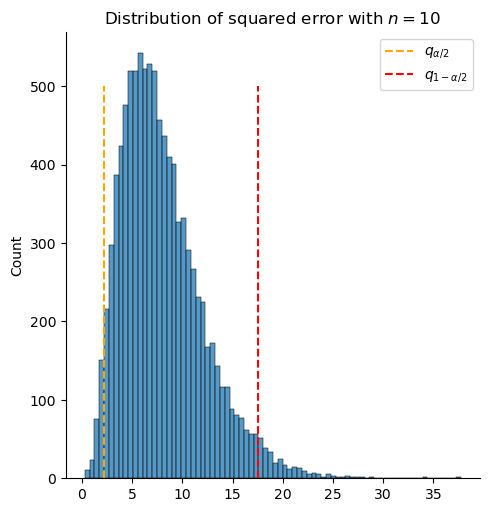

In [35]:
proba = squared_error_interval(
    beta= np.array([0,1]),
    sigma = 0.1,
)

print(f"P(error is in Int({n})) = {np.sum(proba)/ len(proba)}")


P(error is in Int(10)) = 0.9502


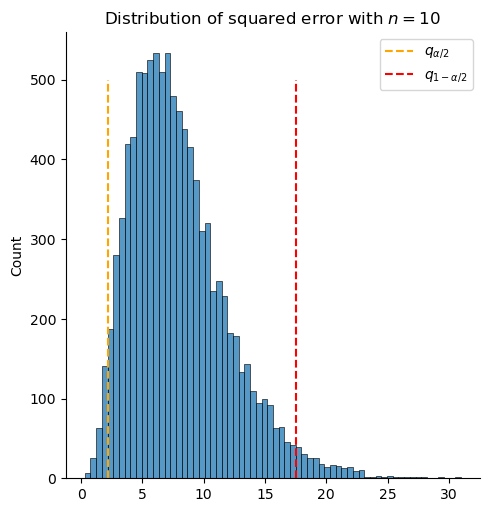

In [36]:
proba = squared_error_interval(
    beta= np.array([1,0]),
    sigma = 0.1,
)

print(f"P(error is in Int({n})) = {np.sum(proba)/ len(proba)}")


P(error is in Int(10)) = 0.9505


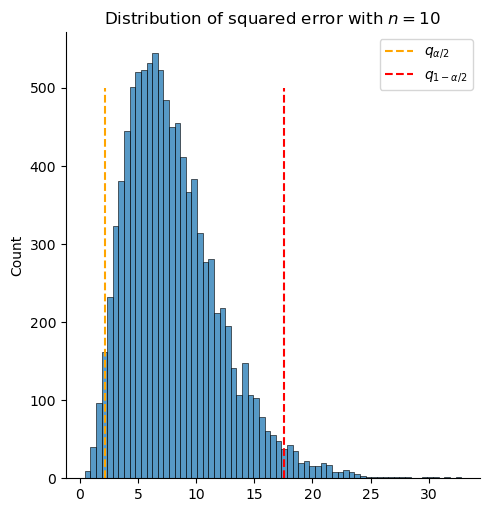

In [37]:
proba = squared_error_interval(
    beta= np.array([1,2]),
    sigma = 0.1,
)

print(f"P(error is in Int({n})) = {np.sum(proba)/ len(proba)}")
